<a href="https://colab.research.google.com/github/SangBejoo/AIMLABTEST/blob/main/SebelumModelUnetKomplexitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset          Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           1835         80  1.0              
nelgiriyewithana/countries-of-the-world-2023                      Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33            788         36  1.0              
shuvammandal121/9000-companies-and-its-ratings-dataset            9000 companies and its ratings dataset              202KB  2023-07-12 04:52:05            477         25  1.0     

In [20]:
!pip install tensorflow

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [21]:
# Setting size parameters of images
im_width = 256
im_height = 256

In [6]:
import zipfile
from glob import glob

# Extract the zip file
zip_path = 'lgg-mri-segmentation.zip'  # Replace with the path to your downloaded zip file
extract_dir = 'Datasets'
# Replace with the path to the folder where you want to extract the files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load image filenames
image_filenames_train = []

# Update the path to the extracted folder
mask_files = glob('/content/Datasets/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

# Verify the loaded filenames
print(image_filenames_train[:10])

# Check the number of loaded filenames
print(len(image_filenames_train))


['/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_3.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_4.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_19.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_17.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_2.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_13.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_18.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_5.tif', '/content/Datasets/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_9.tif']
3929


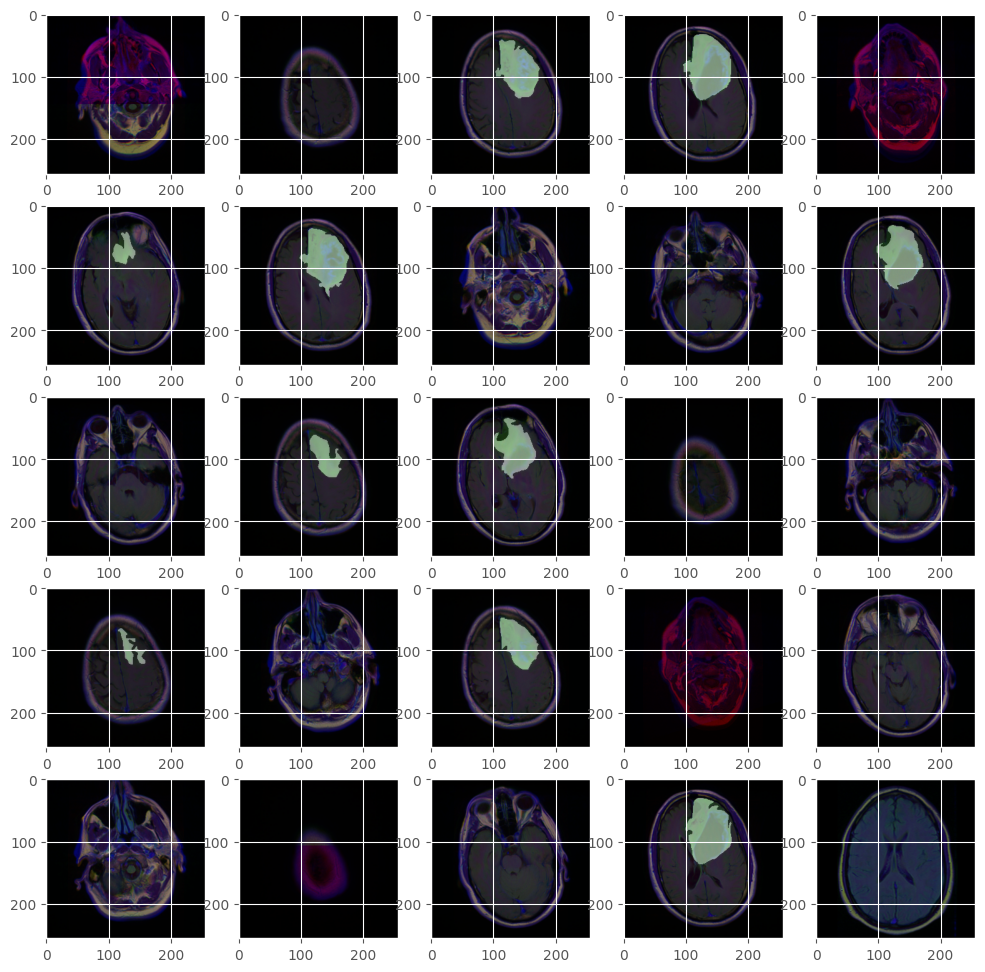

In [7]:
plot_from_img_path(5, 5 , image_filenames_train, mask_files )

In [8]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [9]:
''' After mask Normalization if the value is <= 0.5 then that Mask
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)


In [10]:
EPOCHS = 5
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [11]:
model = unet()
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f7f7d170d00>>

In [12]:
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Create the DataFrame with the appropriate column names
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

# Split the data into train, test, and validation sets
df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.2)

# Print the shapes of the datasets
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

# Rest of the code...
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
opt = tf.keras.optimizers.legacy.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

# Compile the model
model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)


(2828, 2)
(393, 2)
(708, 2)
Found 2828 validated image filenames.
Found 2828 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
89/88 [==============================] - ETA: -1s - loss: -0.1017 - binary_accuracy: 0.9099 - iou: 0.0550 - dice_coefficients: 0.1026Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02036, saving model to unet.hdf5
88/88 [==============================] - 231s 2s/step - loss: -0.1017 - binary_accuracy: 0.9099 - iou: 0.0550 - dice_coefficients: 0.1026 - val_loss: -0.0204 - val_binary_accuracy: 0.9904 - val_iou: 0.0107 - val_dice_coefficients: 0.0210
Epoch 2/5
89/88 [==============================] - ETA: 0s - loss: -0.1646 - binary_accuracy: 0.9805 - iou: 0.0909 - dice_coefficients: 0.1646
Epoch 2: val_loss did not improve from -0.02036
88/88 [==============================] - 153s 2s/step - loss: -0.1646 - binary_accuracy: 0.9805 - iou: 0.0909 - dice_coefficients: 0.1646 - val_loss: -0.0183 - val_binary_accuracy: 0.9906 - val_iou: 0.0091 - val_dice_coefficients: 0.0177
Epoch 3/5
89/88 [=======================

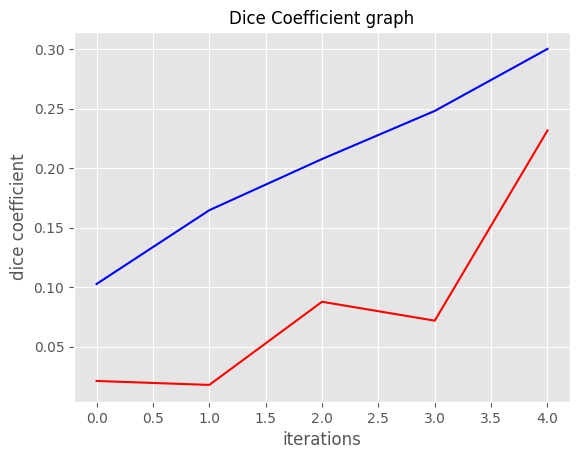

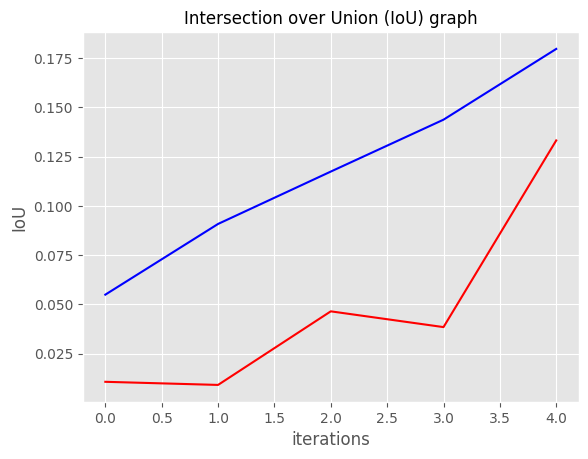

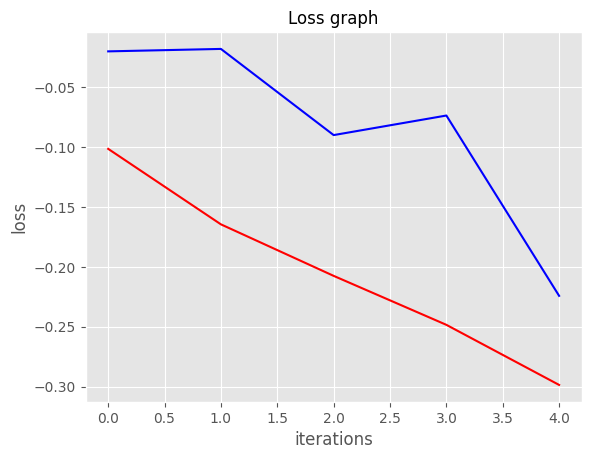

In [13]:
history_post_training = history.history

# Get available metrics from the history
available_metrics = list(history_post_training.keys())

if 'dice_coefficients' in available_metrics:
    train_dice_coeff_list = history_post_training['dice_coefficients']
    test_dice_coeff_list = history_post_training['val_dice_coefficients']
    plt.figure(2)
    plt.plot(train_dice_coeff_list, 'b-')
    plt.plot(test_dice_coeff_list, 'r-')
    plt.xlabel('iterations')
    plt.ylabel('dice coefficient')
    plt.title('Dice Coefficient graph', fontsize=12)
    plt.show()
else:
    print("Dice coefficients not found in model history.")

if 'iou' in available_metrics:
    train_jaccard_list = history_post_training['iou']
    test_jaccard_list = history_post_training['val_iou']
    plt.figure(3)
    plt.plot(train_jaccard_list, 'b-')
    plt.plot(test_jaccard_list, 'r-')
    plt.xlabel('iterations')
    plt.ylabel('IoU')
    plt.title('Intersection over Union (IoU) graph', fontsize=12)
    plt.show()
else:
    print("IoU not found in model history.")

if 'loss' in available_metrics:
    train_loss_list = history_post_training['loss']
    test_loss_list = history_post_training['val_loss']
    plt.figure(1)
    plt.plot(test_loss_list, 'b-')
    plt.plot(train_loss_list, 'r-')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('Loss graph', fontsize=12)
    plt.show()
else:
    print("Loss not found in model history.")


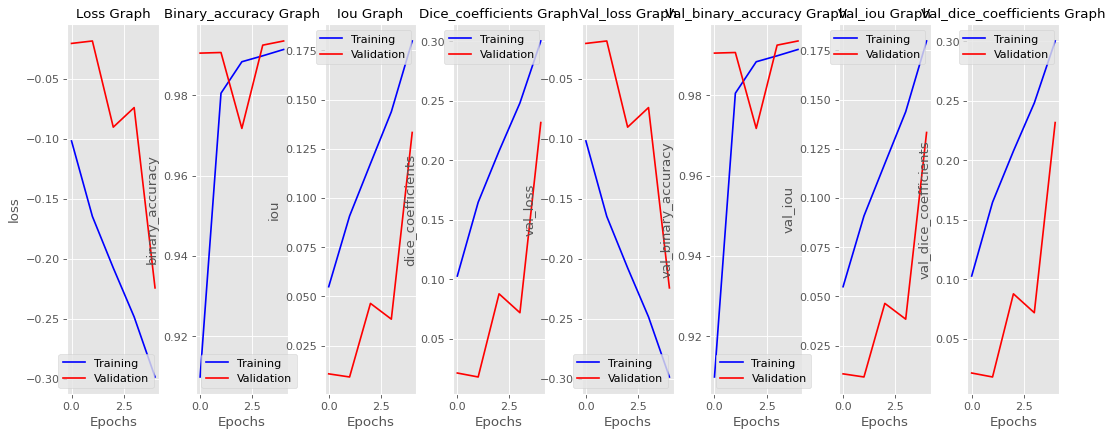

In [14]:
import matplotlib.pyplot as plt

# Set figure size and resolution for the metrics graph
fig, axs = plt.subplots(1, len(available_metrics), figsize=(16, 6), dpi=80)

for i, metric in enumerate(available_metrics):
    if metric.startswith('val_'):
        train_metric_list = history_post_training[metric.replace('val_', '')]
        val_metric_list = history_post_training[metric]
    else:
        train_metric_list = history_post_training[metric]
        val_metric_list = history_post_training['val_' + metric]

    # Plot the training and validation metrics
    axs[i].plot(train_metric_list, 'b-', label='Training')
    axs[i].plot(val_metric_list, 'r-', label='Validation')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(metric)
    axs[i].set_title(metric.capitalize() + ' Graph', fontsize=12)
    axs[i].legend()

# Adjust spacing between subplots in the graph figure
plt.subplots_adjust(wspace=0.4)

# Display the metrics graph
plt.show()


In [15]:
model = load_model('unet.hdf5', custom_objects={
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
})

test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

print('Test Loss:', results[0])
print('Test IoU:', results[1])
print('Test Dice Coefficient:', results[2])


Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 12s 942ms/step - loss: -0.2566 - binary_accuracy: 0.9921 - iou: 0.1543 - dice_coefficients: 0.2640
Test Loss: -0.256635844707489
Test IoU: 0.9921015501022339
Test Dice Coefficient: 0.15428808331489563


Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 6s 472ms/step - loss: -0.2566 - binary_accuracy: 0.9921 - iou: 0.1543 - dice_coefficients: 0.2640


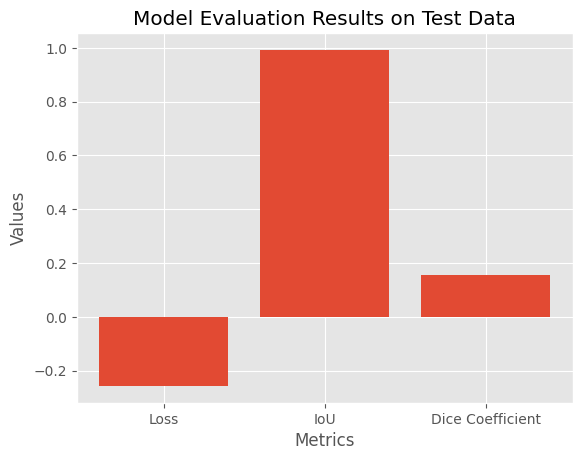

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = load_model('unet.hdf5', custom_objects={
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
})

# Evaluate the model on the test dataset
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

# Extract the evaluation metrics
test_loss = results[0]
test_iou = results[1]
test_dice_coeff = results[2]

# Plot the evaluation results
metrics = ['Loss', 'IoU', 'Dice Coefficient']
values = [test_loss, test_iou, test_dice_coeff]

plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Results on Test Data')
plt.show()


In [17]:
model = load_model('unet.hdf5', custom_objects={
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
})

test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

test_loss = results[0]
test_iou = results[1]
test_dice_coefficient = results[2]

test_iou_percentage = test_iou * 100
test_dice_coefficient_percentage = test_dice_coefficient * 100

print('Test Loss:', test_loss)
print('Test IoU: {:.2f}%'.format(test_iou_percentage))
print('Test Dice Coefficient: {:.2f}%'.format(test_dice_coefficient_percentage))


Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 6s 484ms/step - loss: -0.2566 - binary_accuracy: 0.9921 - iou: 0.1543 - dice_coefficients: 0.2640
Test Loss: -0.256635844707489
Test IoU: 99.21%
Test Dice Coefficient: 15.43%


In [18]:
model = load_model('unet.hdf5', custom_objects={
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
})

test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

test_loss = results[0]
test_accuracy = results[1] * 100

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 6s 484ms/step - loss: -0.2566 - binary_accuracy: 0.9921 - iou: 0.1543 - dice_coefficients: 0.2640
Test Loss: -0.256635844707489
Test Accuracy: 99.21015501022339
